# Momentum
我们提到，目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。对于noisy gradient,我们需要谨慎的选取学习率和batch size, 来控制梯度方差和收敛的结果。


$$
\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{g}_{i, t-1}.
$$


## An ill-conditioned Problem

Condition Number of Hessian Matrix:
   
$$
 cond_{H} = \frac{\lambda_{max}}{\lambda_{min}} 
$$
 
where $\lambda_{max}, \lambda_{min}$ is the maximum amd minimum eignvalue of Hessian matrix.

让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数:


$$
 f(\boldsymbol{x})=0.1x_1^2+2x_2^2
$$



$$
 cond_{H} = \frac{4}{0.2} = 20 \quad \rightarrow \quad \text{ill-conditioned} 
$$
 

## Maximum Learning Rate
+ For $f(x)$, according to convex optimizaiton conclusions, we need step size $\eta$.
+ To guarantee the convergence, we need to have $\eta$ .

## Supp: Preconditioning

在二阶优化中，我们使用Hessian matrix的逆矩阵(或者pseudo inverse)来左乘梯度向量 $i.e. \Delta_{x} = H^{-1}\mathbf{g}$，这样的做法称为precondition，相当于将 $H$ 映射为一个单位矩阵，拥有分布均匀的Spectrum，也即我们去优化的等价标函数的Hessian matrix为良好的identity matrix。

黑塞矩阵(Hessian matrix)常用于牛顿法解决优化问题，利用黑塞矩阵可判定多元函数的极值问题。在工程实际问题的优化设计中，所列的目标函数往往很复杂，为了使问题简化，常常将目标函数在某点邻域展开成泰勒多项式来逼近原函数，此时函数在某点泰勒展开式的矩阵形式中会涉及到黑塞矩阵。

这里将$x_1^2$系数从$1$减小到了$0.1$。下面实现基于这个目标函数的梯度下降，并演示使用学习率为$0.4$时自变量的迭代轨迹。

epoch 20, x1 -0.943467, x2 -0.000073


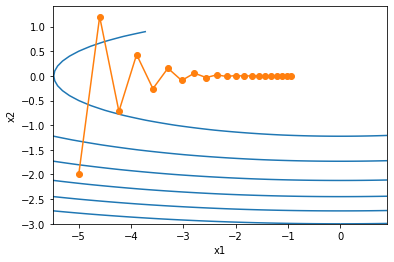

In [8]:
%matplotlib inline
import sys
import d2lzh1981 as d2l
import torch
import os
import numpy as np
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'data')
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（$x_2$轴方向）比在水平方向（$x_1$轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

下面我们试着将学习率调得稍大一点，此时自变量在竖直方向不断越过最优解并逐渐发散。

### Solution to ill-condition
+ __Preconditioning gradient vector__: applied in Adam, RMSProp, AdaGrad, Adelta, KFC, Natural gradient and other secord-order optimization algorithms.
+ __Averaging history gradient__: like momentum, which allows larger learning rates to accelerate convergence; applied in Adam, RMSProp, SGD momentum. 

epoch 20, x1 -0.387814, x2 -1673.365109


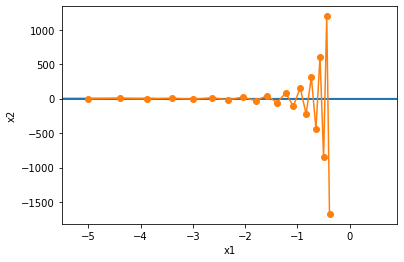

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

## Momentum Algorithm

动量法的提出是为了解决梯度下降的上述问题。设时间步 $t$ 的自变量为 $\boldsymbol{x}_t$，学习率为 $\eta_t$。
在时间步 $t=0$，动量法创建速度变量 $\boldsymbol{m}_0$，并将其元素初始化成 0。在时间步 $t>0$，动量法对每次迭代的步骤做如下修改：


$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{m}_t,
\end{aligned}
$$

Another version:

$$
\begin{aligned}
\boldsymbol{m}_t &\leftarrow \beta \boldsymbol{m}_{t-1} + (1-\beta) \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,
\end{aligned}
$$

$$
\alpha_t = \frac{\eta_t}{1-\beta} 
$$

其中，动量超参数 $\beta$满足 $0 \leq \beta < 1$。当 $\beta=0$ 时，动量法等价于小批量随机梯度下降。

在解释动量法的数学原理前，让我们先从实验中观察梯度下降在使用动量法后的迭代轨迹。

epoch 20, x1 -0.062843, x2 0.001202


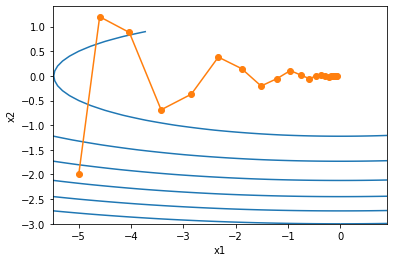

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + eta * 0.2 * x1
    v2 = beta * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, beta = 0.4, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

可以看到使用较小的学习率 $\eta=0.4$ 和动量超参数 $\beta=0.5$ 时，动量法在竖直方向上的移动更加平滑，且在水平方向上更快逼近最优解。下面使用较大的学习率 $\eta=0.6$，此时自变量也不再发散。

epoch 20, x1 0.007188, x2 0.002553


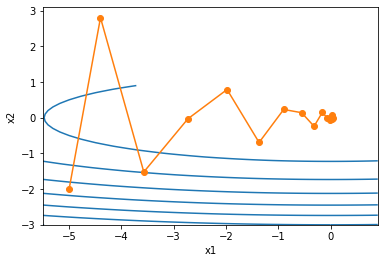

In [4]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### 指数加权移动平均(Exponential Moving Average)

为了从数学上理解动量法，让我们先解释一下指数加权移动平均（exponential moving average）。给定超参数 $0 \leq \beta < 1$，当前时间步 $t$ 的变量 $y_t$ 是上一时间步 $t-1$ 的变量 $y_{t-1}$ 和当前时间步另一变量 $x_t$ 的线性组合：

$$
y_t = \beta y_{t-1} + (1-\beta) x_t.
$$

我们可以对 $y_t$ 展开：

$$
\begin{aligned}
y_t  &= (1-\beta) x_t + \beta y_{t-1}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + \beta^2y_{t-2}\\
         &= (1-\beta)x_t + (1-\beta) \cdot \beta x_{t-1} + (1-\beta) \cdot \beta^2x_{t-2} + \beta^3y_{t-3}\\
         &= (1-\beta) \sum_{i=0}^{t} \beta^{i}x_{t-i}
\end{aligned}
$$

$$
(1-\beta)\sum_{i=0}^{t} \beta^{i} = \frac{1-\beta^{t}}{1-\beta} (1-\beta) = (1-\beta^{t})
$$

### Supp
Approximate Average of $\frac{1}{1-\beta}$ Steps

令 $n = 1/(1-\beta)$，那么 $\left(1-1/n\right)^n = \beta^{1/(1-\beta)}$。因为

$$
 \lim_{n \rightarrow \infty}  \left(1-\frac{1}{n}\right)^n = \exp(-1) \approx 0.3679,
$$

所以当 $\beta \rightarrow 1$时，$\beta^{1/(1-\beta)}=\exp(-1)$，如 $0.95^{20} \approx \exp(-1)$。如果把 $\exp(-1)$ 当作一个比较小的数，我们可以在近似中忽略所有含 $\beta^{1/(1-\beta)}$ 和比 $\beta^{1/(1-\beta)}$ 更高阶的系数的项。例如，当 $\beta=0.95$ 时，

$$
y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}.
$$

因此，在实际中，我们常常将 $y_t$ 看作是对最近 $1/(1-\beta)$ 个时间步的 $x_t$ 值的加权平均。例如，当 $\gamma = 0.95$ 时，$y_t$ 可以被看作对最近20个时间步的 $x_t$ 值的加权平均；当 $\beta = 0.9$ 时，$y_t$ 可以看作是对最近10个时间步的 $x_t$ 值的加权平均。而且，离当前时间步 $t$ 越近的 $x_t$ 值获得的权重越大（越接近1）。


### 由指数加权移动平均理解动量法

现在，我们对动量法的速度变量做变形：

$$
\boldsymbol{m}_t \leftarrow \beta \boldsymbol{m}_{t-1} + (1 - \beta) \left(\frac{\eta_t}{1 - \beta} \boldsymbol{g}_t\right). 
$$

Another version:

$$
\boldsymbol{m}_t \leftarrow \beta \boldsymbol{m}_{t-1} + (1 - \beta) \boldsymbol{g}_t. 
$$


$$
\begin{aligned}
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \alpha_t \boldsymbol{m}_t,
\end{aligned}
$$


$$
\alpha_t = \frac{\eta_t}{1-\beta} 
$$


由指数加权移动平均的形式可得，速度变量 $\boldsymbol{v}_t$ 实际上对序列 $\{\eta_{t-i}\boldsymbol{g}_{t-i} /(1-\beta):i=0,\ldots,1/(1-\beta)-1\}$ 做了指数加权移动平均。换句话说，相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量近似于将前者对应的最近 $1/(1-\beta)$ 个时间步的更新量做了指数加权移动平均后再除以 $1-\beta$。所以，在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。在本节之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。


## Implement

相对于小批量随机梯度下降，动量法需要对每一个自变量维护一个同它一样形状的速度变量，且超参数里多了动量超参数。实现中，我们将速度变量用更广义的状态变量`states`表示。

In [9]:
def get_data_ch7():  
    data = np.genfromtxt(os.path.join(DATA_DIR,'19airfoil_self_noise.dat'), delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)

features, labels = get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.243594, 0.053841 sec per epoch


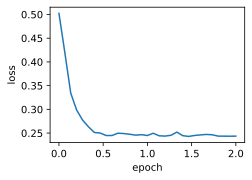

In [10]:
# 动量为0.5
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.5}, features, labels)

loss: 0.246105, 0.058848 sec per epoch


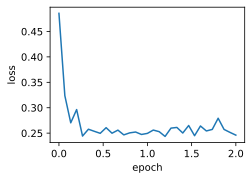

In [11]:
# 动量为0.9
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

可见目标函数值在后期迭代过程中的变化不够平滑。直觉上，10倍小批量梯度比2倍小批量梯度大了5倍，我们可以试着将学习率减小到原来的1/5。此时目标函数值在下降了一段时间后变化更加平滑。

loss: 0.248394, 0.053842 sec per epoch


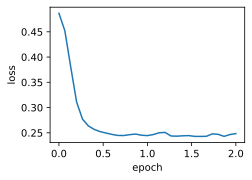

In [12]:
# 调整学习率
d2l.train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

### Pytorch Class
在Pytorch中，```torch.optim.SGD```已实现了Momentum。

loss: 0.241827, 0.046850 sec per epoch


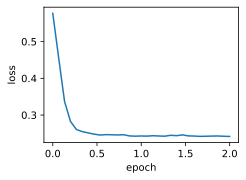

In [13]:
d2l.train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

## 11.7 AdaGrad

在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为$f$，自变量为一个二维向量$[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为$\eta$的梯度下降中，元素$x_1$和$x_2$都使用相同的学习率$\eta$来自我迭代：


$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$


在[“动量法”](./momentum.ipynb)一节里我们看到当$x_1$和$x_2$的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题 [1]。


### Algorithm

AdaGrad算法会使用一个小批量随机梯度$\boldsymbol{g}_t$按元素平方的累加变量$\boldsymbol{s}_t$。在时间步0，AdaGrad将$\boldsymbol{s}_0$中每个元素初始化为0。在时间步$t$，首先将小批量随机梯度$\boldsymbol{g}_t$按元素平方后累加到变量$\boldsymbol{s}_t$：


$$
\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,
$$


其中$\odot$是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

### Feature

需要强调的是，小批量随机梯度按元素平方的累加变量$\boldsymbol{s}_t$出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\boldsymbol{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

下面我们仍然以目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$为例观察AdaGrad算法对自变量的迭代轨迹。我们实现AdaGrad算法并使用和上一节实验中相同的学习率0.4。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


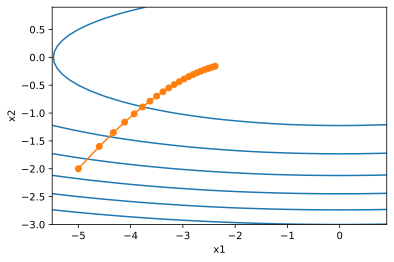

In [14]:
%matplotlib inline
import math
import torch
import sys
import d2lzh1981 as d2l

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 -0.000000


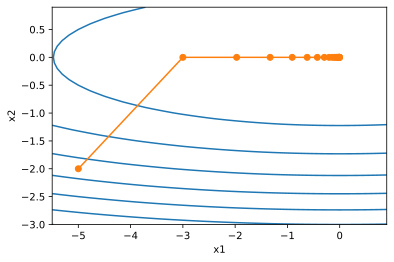

In [15]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## Implement

同动量法一样，AdaGrad算法需要对每个自变量维护同它一样形状的状态变量。我们根据AdaGrad算法中的公式实现该算法。

In [17]:
def get_data_ch7():  
    data = np.genfromtxt(os.path.join(DATA_DIR,'19airfoil_self_noise.dat'), delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.242347, 0.057849 sec per epoch


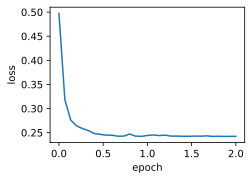

In [18]:
d2l.train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

loss: 0.242723, 0.051865 sec per epoch


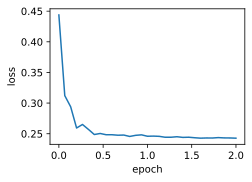

In [19]:
d2l.train_pytorch_ch7(torch.optim.Adagrad, {'lr': 0.1}, features, labels)

## 11.8 RMSProp

AdaGrad算法一节中提到，因为调整学习率时分母上的变量$\boldsymbol{s}_t$一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，RMSProp算法对AdaGrad算法做了修改。该算法源自Coursera上的一门课程，即“机器学习的神经网络”。

### Algorithm

动量法一节里介绍过指数加权移动平均。不同于AdaGrad算法里状态变量$\boldsymbol{s}_t$是截至时间步$t$所有小批量随机梯度$\boldsymbol{g}_t$按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数$0 \leq \gamma 0$计算


$$
\boldsymbol{v}_t \leftarrow \beta \boldsymbol{v}_{t-1} + (1 - \beta) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\alpha}{\sqrt{\boldsymbol{v}_t + \epsilon}} \odot \boldsymbol{g}_t, 
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。因为RMSProp算法的状态变量$\boldsymbol{s}_t$是对平方项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$的指数加权移动平均，所以可以看作是最近$1/(1-\beta)$个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察RMSProp算法对目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$中自变量的迭代轨迹。回忆在AdaGrad算法一节使用的学习率为0.4的AdaGrad算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，RMSProp算法可以更快逼近最优解。

epoch 20, x1 -0.010599, x2 0.000000


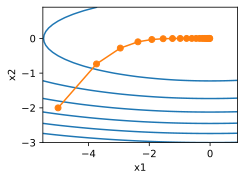

In [20]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = beta * s1 + (1 - beta) * g1 ** 2
    s2 = beta * s2 + (1 - beta) * g2 ** 2
    x1 -= alpha / math.sqrt(s1 + eps) * g1
    x2 -= alpha / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

alpha, beta = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [21]:
def get_data_ch7():  
    data = np.genfromtxt(os.path.join(DATA_DIR,'19airfoil_self_noise.dat'), delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['beta'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.243549, 0.065823 sec per epoch


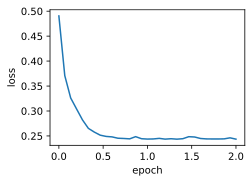

In [22]:
d2l.train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'beta': 0.9},
              features, labels)

loss: 0.244665, 0.048867 sec per epoch


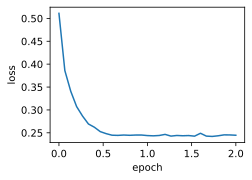

In [23]:
d2l.train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                    features, labels)

## 11.9 AdaDelta

除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，AdaDelta算法没有学习率这一超参数。

### Algorithm

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$\boldsymbol{g}_t$按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho 0$，同RMSProp算法一样计算


$$
\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用$\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：


$$
 \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t, 
$$


其中$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-5}$。接着更新自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. 
$$


最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：


$$
\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. 
$$


可以看到，如不考虑$\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用$\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代超参数$\eta$。


### Implement

AdaDelta算法需要对每个自变量维护两个状态变量，即$\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [24]:
def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.243751, 0.075794 sec per epoch


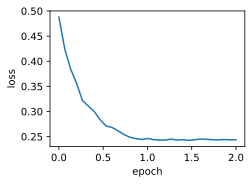

In [25]:
d2l.train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

loss: 0.262382, 0.058842 sec per epoch


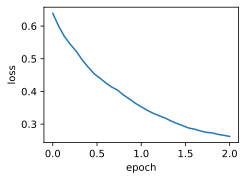

In [26]:
d2l.train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

## Adam

Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

### Algorithm

Adam算法使用了动量变量$\boldsymbol{m}_t$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{v}_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$\boldsymbol{m}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：


$$
\boldsymbol{m}_t \leftarrow \beta_1 \boldsymbol{m}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. 
$$


和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{v}_t$：


$$
\boldsymbol{v}_t \leftarrow \beta_2 \boldsymbol{v}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. 
$$


由于我们将$\boldsymbol{m}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，
在时间步$t$我们得到$\boldsymbol{m}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{m}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{m}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$\boldsymbol{m}_t$和$\boldsymbol{v}_t$均作偏差修正：


$$
\hat{\boldsymbol{m}}_t \leftarrow \frac{\boldsymbol{m}_t}{1 - \beta_1^t}, 
$$



$$
\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_2^t}. 
$$



接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{m}}_t$和$\hat{\boldsymbol{m}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：


$$
\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{m}}_t}{\sqrt{\hat{\boldsymbol{v}}_t} + \epsilon},
$$


其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：


$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. 
$$


### Implement

我们按照Adam算法中的公式实现该算法。其中时间步$t$通过`hyperparams`参数传入`adam`函数。

In [28]:
def get_data_ch7():  
    data = np.genfromtxt(os.path.join(DATA_DIR,'19airfoil_self_noise.dat'), delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
        torch.tensor(data[:1500, -1], dtype=torch.float32)
        
features, labels = get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.245492, 0.077819 sec per epoch


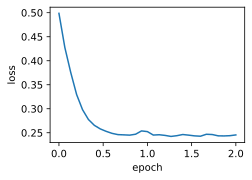

In [29]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

loss: 0.244278, 0.053856 sec per epoch


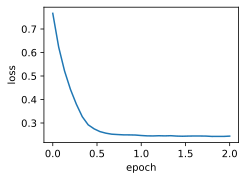

In [30]:
d2l.train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)